# Gradient descent

In [0]:
import numpy as np
import ipywidgets as widgets
from scipy.optimize import approx_fprime

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

Some functions I was planning to use

Peaks function

In [0]:
peaks_xy = lambda x, y: 3*(1-x)**2*np.exp(-(x**2)-(y+1)**2) - 10*(x/5 - x**3 - y**5)*np.exp(-x**2-y**2) - 1/3*np.exp(-(x+1)**2 - y**2)
def peaks(X):
  if X.ndim == 1:
    return peaks_xy(X[0], X[1])
  else:
    return peaks_xy(X[:, 0], X[:, 1])

# d/dx  -10 (1/5 - 3 x^2) e^(-x^2 - y^2) - 6 x (1 - x)^2 e^(-x^2 - (y + 1)^2) - 6 (1 - x) e^(-x^2 - (y + 1)^2) + 20 x e^(-x^2 - y^2) (-x^3 + x/5 - y^5) + 2/3 (x + 1) e^(-(x + 1)^2 - y^2)
# d/dy  50 y^4 e^(-x^2 - y^2) - 6 (1 - x)^2 (y + 1) e^(-x^2 - (y + 1)^2) + 20 y e^(-x^2 - y^2) (-x^3 + x/5 - y^5) + 2/3 y e^(-(x + 1)^2 - y^2)

Eliptic bowl

In [0]:
# def EllipticBowl(x, y):
#   return x ** 2 + .1 * y ** 2

# def EllipticBowlPrime(x, y):
#   return [2 * x, .2 * y]

## Rosenbrock

Set up using the Rosenbrock function for testing GD

In [0]:
from scipy.optimize import rosen, rosen_der

f = rosen
f_prime = rosen_der

xx, yy = np.meshgrid(np.linspace(-2, 2, 40), np.linspace(-1, 3, 40))
cords = np.c_[xx.ravel(), yy.ravel()]
Z = np.apply_along_axis(f, 1, cords)
Z = Z.reshape(xx.shape)

levels = list(np.asarray(np.linspace(np.sqrt(Z.min()), np.sqrt(Z.max()), 15)**2, dtype=np.int))

Now to show how the function looks in 3d and as level sets from above

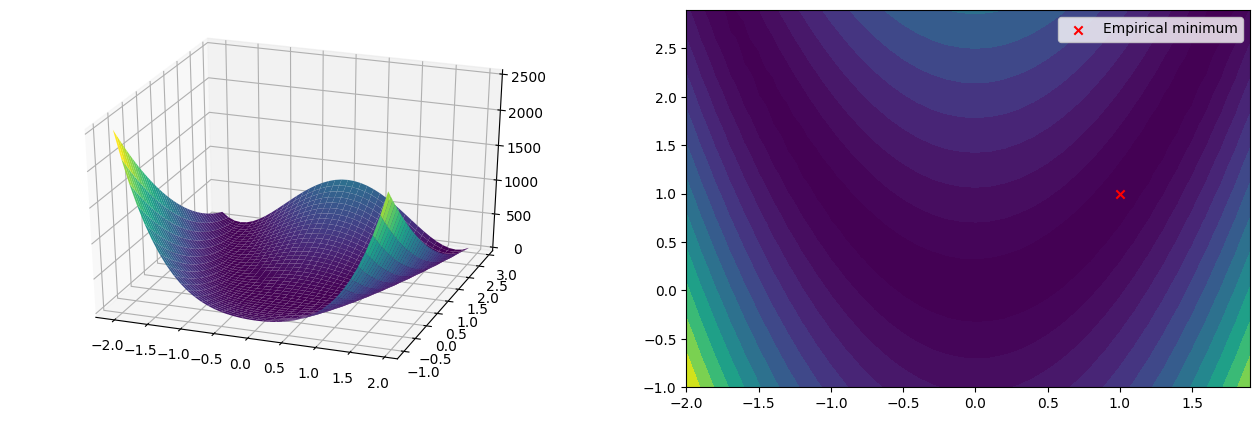

In [0]:
xx, yy = np.meshgrid(np.arange(-2, 2, .1), np.arange(-1, 3, .1))
cords = np.c_[xx.ravel(), yy.ravel()]
Z = np.apply_along_axis(f, 1, cords)
theta = cords[np.argmin(Z)]
Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(16, 5), dpi=100)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(xx, yy, Z, rstride=1, cstride=1, cmap='viridis')
# ax.scatter(theta[0], theta[1], f(theta)+10, c='r', marker='x', label="Empirical minimum")
# ax.legend()
ax.view_init(30, -70)

ax = fig.add_subplot(1, 2, 2)
cs = ax.contourf(xx, yy, Z, cmap='viridis', levels=levels)
ax.scatter(theta[0], theta[1], c='r', marker='x', label="Empirical minimum")
ax.legend()
fig.show()

In [0]:
def lineplot(x_0, x_1, log_learning_rate, h, max_iter):
  f_prime_approx = lambda x: approx_fprime(x, f, h)

  path = [np.asarray([x_0, x_1])]
  path_approx = [np.asarray([x_0, x_1])]
  for i in range(max_iter):
    path.append(path[-1] - 10**log_learning_rate*f_prime(path[-1]))
    # if np.linalg.norm(path[-1]) > 20:
    #   break
  for i in range(max_iter):
    path_approx.append(path_approx[-1] - 10**log_learning_rate*f_prime_approx(path_approx[-1]))
    # if np.linalg.norm(path_approx[-1]) > 20:
    #   break

  fig = plt.figure(figsize=(5, 5), dpi=100)
  ax = fig.add_subplot(1, 1, 1)
  cs = ax.contour(xx, yy, Z, cmap='jet', levels=levels)

  ax.scatter(x_0, x_1, c='g', marker='x')

  ax.plot([path[i][0] for i in range(len(path))], [path[i][1] for i in range(len(path))], 
          'b-', alpha=.7, label="Analytical gradient path")
  ax.plot([path_approx[i][0] for i in range(len(path_approx))], [path_approx[i][1] for i in range(len(path_approx))], 
          'r-', alpha=.7, label="Approximated gradient path")

  ax.legend()
  ax.set_xlabel("$x_0$")
  ax.set_ylabel("$x_1$")
  fig.show()

widg = widgets.interactive(lineplot, x_0=(-2, 2, 0.1), x_1=(-1, 3, 0.1), log_learning_rate=(-6, -.5, .1), h=(.01, .1, 0.01), max_iter=(5, 200, 5))
sliders = widgets.VBox([widg.children[0], widg.children[1], widg.children[2], widg.children[3], widg.children[4]])
widgets.HBox([widg.children[5], sliders])

### Importance of a good start

Again, when starting your optimization, the choise of starting point might limit how good your end results can be.

In [0]:
from scipy.optimize import minimize

n_restarts = 300

def c(xk):
  global x
  x = np.concatenate((x, [xk]))
  return True

paths_scipy = list()
for i in range(n_restarts):
  x = np.random.uniform(-3, 3, size=(1, 2))
  res = minimize(lambda x: -peaks(x), x, bounds=[(-3, 3), (-3, 3)], callback=c)
  paths_scipy.append(x)

In [0]:
from scipy.optimize import approx_fprime

n_restarts = 300
n_maxiter = 100

paths = list()
for i in range(n_restarts):
  x = np.random.uniform(-3, 3, size=(1, 2))
  for j in range(n_maxiter):
    gradient = approx_fprime(x[-1, :], peaks, epsilon=0.01)
    gradient *= .05/np.linalg.norm(gradient)
    new_x = x[-1, :] + gradient
    if peaks(new_x) > peaks(x[-1, :]) and -3 < new_x[0] and new_x[0] < 3 \
      and -3 < new_x[1] and new_x[1] < 3:
      x = np.concatenate((x, [new_x]))
    else:
      break
  paths.append(x)

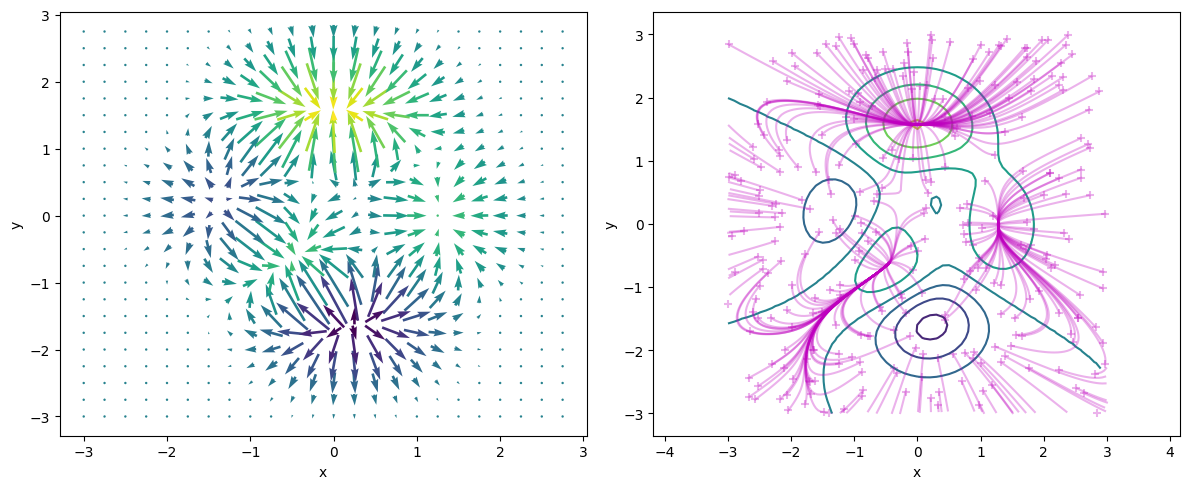

In [0]:
fig = plt.figure(figsize=(12, 5), dpi=100)
ax = fig.add_subplot(1, 2, 1)

sparse_xx, sparse_yy = np.meshgrid(np.arange(-3, 3, .25), np.arange(-3, 3, .25))
sparse_grid = np.c_[sparse_xx.ravel(), sparse_yy.ravel()]
gradient = np.zeros((sparse_grid.shape[0], 2))
for i in range(sparse_grid.shape[0]):
  gradient[i, :] = approx_fprime(sparse_grid[i, :], peaks, epsilon=0.01)
U = gradient[:, 0].reshape(sparse_xx.shape)
V = gradient[:, 1].reshape(sparse_xx.shape)
C = peaks(sparse_grid).reshape(sparse_xx.shape)

ax.quiver(sparse_xx, sparse_yy, U, V, C, cmap='viridis', width=.005, pivot='middle')
ax.set_xlabel("x")
ax.set_ylabel("y")

ax = fig.add_subplot(1, 2, 2)

xx, yy = np.meshgrid(np.arange(-3, 3, .1), np.arange(-3, 3, .1))
cords = np.c_[xx.ravel(), yy.ravel()]
Z = np.apply_along_axis(peaks, 1, cords)
Z = Z.reshape(xx.shape)

ax.contour(xx, yy, Z, cmap='viridis')
for path in paths:
  ax.scatter(path[0, 0], path[0, 1], marker='+', c='m', alpha=.3)
  ax.plot(path[:, 0], path[:, 1], 'm-', alpha=.3)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.axis('equal')
fig.tight_layout()
fig.show()